In [14]:
# part 1 __Tech_Panel__

In [15]:
# packages load
import requests
import json
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

'''
There are two strategy to approach this problem:
1) Crawl all countries sanitation facility using http://api.worldbank.org/v2/countries/all/indicators/SH.STA.ACSN?format=json&date=1960:2018
for all 290 pages. Then use income group information to create a dictionary to group countries with sae income level together
and take sum to compare if sanitation development vary by income group

2) Crawl data based on income group based on (income level code) https://datahelpdesk.worldbank.org/knowledgebase/articles/898614
I used the second solution.

Also, I made some assumptions for this problem: 

1) Assume sanitation facility access data means sanitation quality
2) Assume sanitation data we have are recorded per year, instead of cumulative. Thus I will add all sanitation before
one year to it's current data.

'''

In [16]:
# variables initiating
income_level_list = ['lic','lmc','umc','hic'] 
income_level_legend =['Low Income','Low Middle Income','Upper Middle Income','Hight Income']

In [17]:
code_i="SH.STA.ACSN"
start_time = 1960
end_time = 2018
_format ='json'
time_range = end_time - start_time

In [18]:
def crawl(search_var_list, code, start_time, end_time,_format,cumulative):
    all_data = {}
    graph_data = {} # nested dictionary: used for later visualization
    for i in search_var_list:
        income_level = i
        graph_data[income_level]= {}
        graph_data[income_level]['sanitation_facility_amount'] = []
        graph_data[income_level]['year'] =[]
        argument_i = "http://api.worldbank.org/v2/countries/" + income_level + "/indicators/" + code_i + "?per_page=" + str(
    time_range) + "&format=" + _format + "&date=" + str(start_time) + ":" + str(end_time)
        r_i = requests.get(argument_i, auth=('user', 'pass'))
        raw_i = json.loads(r_i.text)
        data_detail_i = raw_i[1]
        cum_sum = 0 # record cumultive sum
        
        for num in range(time_range)[::-1]:
            if cumulative:
                try:
                    cum_sum += data_detail_i[num]['value']
                    graph_data[income_level]['sanitation_facility_amount'] += [cum_sum]
                except:
                    graph_data[income_level]['sanitation_facility_amount'] += [cum_sum]
            else:
                graph_data[income_level]['sanitation_facility_amount'] += [data_detail_i[num]['value']]
                
            graph_data[income_level]['year'] += [data_detail_i[num]['date']]
        
        all_data[income_level] = data_detail_i
    # store data when needed 
#     with open('sanitation_data.txt','w') as file:
#         file.write(json.dumps(all_data))
#         file.write('\n')
    return graph_data

In [19]:
graph_data_1 = crawl(income_level_list, code_i, start_time, end_time,_format,cumulative=False)

In [20]:
graph_data_2 = crawl(income_level_list, code_i, start_time, end_time,_format,cumulative=True)

In [21]:
# How is access to sanitation facilities changing over time per different income group?
# Create data frame for visualizations
df_1 = pd.DataFrame({
"income_level":np.repeat(income_level_legend, time_range), # duplicate income group * year -- (406,)
"years":list(range(start_time, end_time)) * len(income_level_list), # duplicate year  * income group (406,)
"value":np.array([graph_data_1[income_level]['sanitation_facility_amount'] for income_level in income_level_list]).flatten().astype(float)
})

In [22]:
df_2 = pd.DataFrame({
"income_level":np.repeat(income_level_legend, time_range), # duplicate income group * year -- (406,)
"years":list(range(start_time, end_time)) * len(income_level_list), # duplicate year  * income group (406,)
"value":np.array([graph_data_2[income_level]['sanitation_facility_amount'] for income_level in income_level_list]).flatten().astype(float)
})

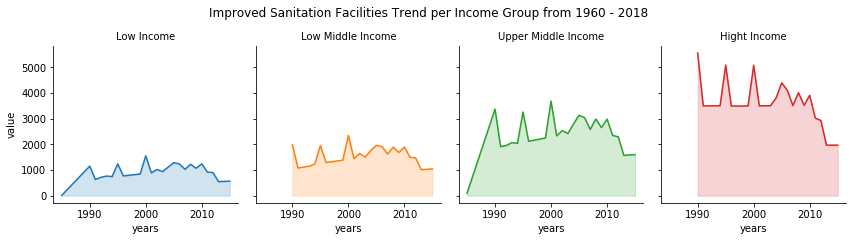

In [23]:
# use Seaborn to create facets for different income level
g = sns.FacetGrid(df_1, col='income_level', hue='income_level', col_wrap=4, )
g = g.map(plt.plot, 'years', 'value')
g = g.map(plt.fill_between, 'years', 'value', alpha=0.2).set_titles("{col_name} income_level")
g = g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Improved Sanitation Facilities Trend per Income Group from 1960 - 2018',y=1.1)
plt.show()

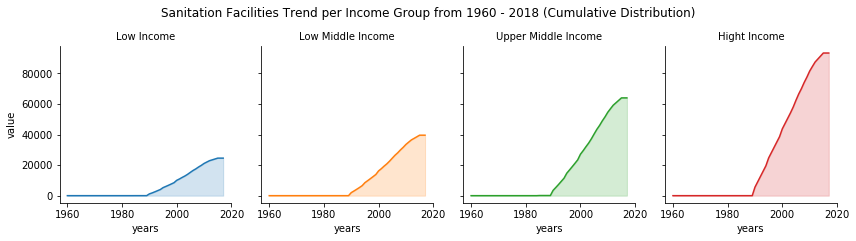

In [24]:
g = sns.FacetGrid(df_2, col='income_level', hue='income_level', col_wrap=4, )
g = g.map(plt.plot, 'years', 'value')
g = g.map(plt.fill_between, 'years', 'value', alpha=0.2).set_titles("{col_name} income_level")
g = g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Sanitation Facilities Trend per Income Group from 1960 - 2018 (Cumulative Distribution)',y=1.1)
plt.show()